# PCA-embedded quantum autoencoder (PQAE) for encoding the MNIST dataset in a variational quantum circuit (VQC)

In this jupyter notebook, I present the implementation of a PCA Quantum autoencoder (PQAE), which is used to encode data into a qiskit VQC. There will be a comparison between the performance of the VQC with the PQAE encoding VS without it (PCA). The dataset in this example is going to be the MNIST dataset, which is transformed to a binary classification problem.

In [ ]:
%%capture
!pip install qiskit_algorithms
!pip install qiskit_machine_learning

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.decomposition import KernelPCA , PCA
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
import random
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from sklearn.svm import SVC
from qiskit.circuit.library import ZZFeatureMap , RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.optimizers import COBYLA
import copy
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_digits

## Set a random seed for reproducibility

In [ ]:
# Function to set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    algorithm_globals.random_seed = seed


# Set seeds
set_seed(2)

## MNIST dataset

Each sample in sklearn's version of MNIST dataset is a grayscale image of a handwritten digit, represented by 8x8 pixels, for a total of 64 pixel values. The goal of this classification task is to predict the digit (0-1) depicted in each image based on these pixel values.

In [ ]:
digit_data = load_digits()

In [ ]:
features = digit_data.data
labels = digit_data.target

mask = np.isin(labels, [0, 1])
features = features[mask]
labels = labels[mask]

In [ ]:
features = MinMaxScaler().fit_transform(features) # Normalize using MinMaxScaler

We split the data in three sets (train-val-test) with a (70%-10%-20%) split. The validation split is going to be needed for the PQAE part and not for the PCA part. Nonetheless, we make the split from now, so that the train and test datasets will be the same.

In [ ]:
train_size = 252
val_size = 36
test_size = 72


train_features, remaining_features, train_labels, remaining_labels = train_test_split(
    features, labels, train_size=train_size, random_state=algorithm_globals.random_seed , stratify=labels
)

val_features, test_features, val_labels, test_labels = train_test_split(
    remaining_features, remaining_labels, test_size=test_size, random_state=algorithm_globals.random_seed, stratify=remaining_labels
)

# SVC training for comparison reasons

We train a classical Support Vector Classifier from scikit-learn. For the sake of simplicity, we don't tweak any parameters and rely on the default values.

In [ ]:
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

Now we check out how well our classical model performs. We will analyze the scores in the conclusion section.

In [ ]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 1.00
Classical SVC on the test dataset:     1.00


# Raw/PCA qiskit

Here we are going to use the PCA reduced data, before passing them in the VQC.

## VQC set up

To set up the components for the VQC model, we utilize a ZZFeatureMap for quantum feature mapping, RealAmplitudes as the ansatz function, and the COBYLA optimizer. The feature map is created according to the dimensions of the input data, while the ansatz function is configured with three repetitions.

The COBYLA optimizer is configured to perform up to 100 iterations. The dataset is then split into training and test sets with an 80-20 ratio using the train_test_split function, ensuring consistency with a fixed random seed. Together, these components configure the VQC model and prepare the dataset for both training and evaluation.

In [ ]:
num_features = 4

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

The RealAmplitudes ansatz will have 3 reps

In [ ]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

In [ ]:
q_optimizer = COBYLA(maxiter=100)

In [ ]:
sampler = Sampler()

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Here we reduce the data to 4 components using PCA

In [ ]:
pca = PCA(n_components=4)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)


The VQC is ran here

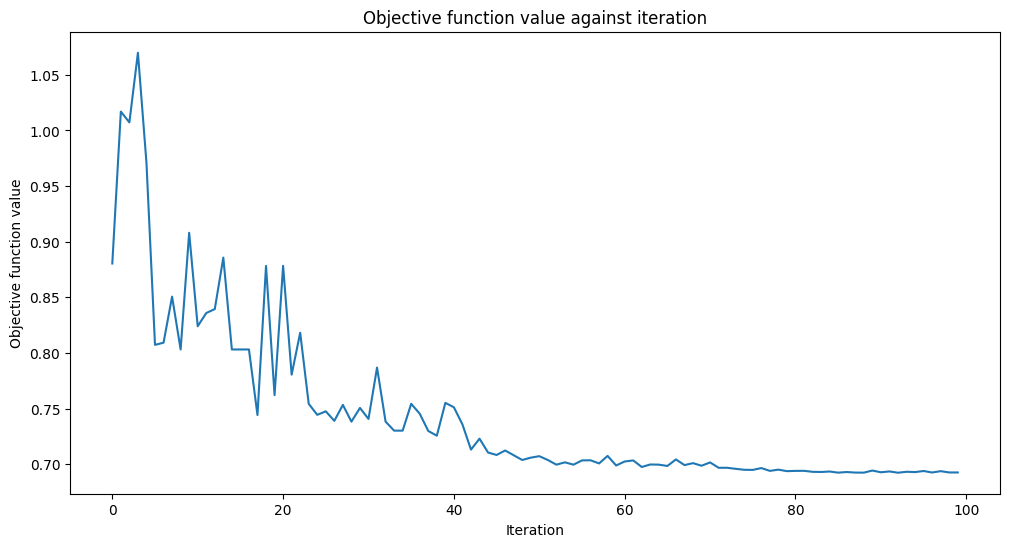

Training time: 212 seconds


In [ ]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=q_optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features_pca, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Let's see how the quantum model performs on the real-life dataset.

In [ ]:
train_score_q4 = vqc.score(train_features_pca, train_labels)
test_score_q4 = vqc.score(test_features_pca, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.79
Quantum VQC on the test dataset:     0.80


According to these 10 random seeds, the highest test score without PQAE is 72.5%. Ofcourse, if we measured another 10 seeds it could be possible that a higher accuracy is achieved.

#  PCA Quantum Autoencoder

Now we will present and implement our novel data encoding algorithm called PQAE. Because we intend to use 4 qubits, and the number of features in MNIST is 64, we will start with an encoder which is 64x4 (the connection of input to hidden layers). Then, these values are going to be passed through the featue map and kernel PCA will be used to reduce the dimensionality to 4. Then, a 4x64 decoding layer generates the output. This type of network encodes the classical data to 4 qubits.  

In [ ]:
seed = 13
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# If using CUDA (GPU), you should also set the seed for CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)



# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size =20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(torch.tensor(np.array(train_features) ), batch_size=batch_size, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(torch.tensor(np.array(val_features) ), batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(torch.tensor(np.array(test_features) ), batch_size=batch_size, num_workers=num_workers)


# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.input = nn.Linear(64, 4, dtype=torch.float64)

        ## decoder ##
        self.decoder = nn.Linear(4,64, dtype=torch.float64)


        # Define the qubit states as column vectors
        self.q0 = torch.tensor([[1], [0]], dtype=torch.cfloat)
        self.q1 = torch.tensor([[0], [1]], dtype=torch.cfloat)

        # Define the Pauli matrices
        self.sigma1 = torch.tensor([[1, 0], [0, 1]], dtype=torch.complex64)
        self.sigma2 = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex64)
        self.sigma3 = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex64)
        self.sigma4 = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex64)

        self.hadamard_gate = 1 / torch.sqrt(torch.tensor(2) ) * torch.tensor([[1, 1], [1, -1]], dtype=torch.complex64)

        # Define the CNOT gate
        self.cnot_gate = torch.tensor([[1, 0, 0, 0],
                                       [0, 1, 0, 0],
                                       [0, 0, 0, 1],
                                       [0, 0, 1, 0]], dtype=torch.complex64)



        # Collect the Pauli matrices in a list
        self.generators = [ self.sigma2, self.sigma3, self.sigma4 ]



    def forward(self, x):
        # define feedforward behavior
        x = self.input(x)    # Here the data are reduced from 64 to 4, which is the number of qubits

        sampler = Sampler()     # Initialize a sampler which samples from the quantum circuit.
        fidelity = ComputeUncompute(sampler=sampler) # ComputeUncompute is a method that uses the compute-uncompute technique to estimate the fidelity.

        # The ZZFeatureMap maps classical data to a quantum state. The 'feature_dimension' parameter specifies the
        # dimensionality of the input data, and 'reps' indicates the number of repetitions of the feature map.
        feature_map = ZZFeatureMap(feature_dimension=4, reps=1)

        # Initialize the quantum kernel with the specified fidelity computation method and feature map.
        # The FidelityQuantumKernel calculates the kernel matrix for quantum data using the fidelity metric.
        qpca_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

        # Evaluate the kernel matrix for the training data.
        # x.detach().numpy() converts the input tensor 'x' to a numpy array.
        matrix_train = qpca_kernel.evaluate(x_vec=x.detach().numpy())

        # Initialize KernelPCA with the number of components and kernel type.
        # KernelPCA is a variant of Principal Component Analysis that uses kernel methods to perform
        # dimensionality reduction in high-dimensional feature spaces. The 'precomputed' kernel indicates
        # that we will provide a precomputed kernel matrix instead of calculating it internally.
        kernel_pca_q = KernelPCA(n_components=4, kernel="precomputed")

        # Fit KernelPCA on the precomputed kernel matrix and transform the training data.
        # This step reduces the dimensionality of the training data to the specified number of components.
        train_features_q = kernel_pca_q.fit_transform(matrix_train)
        logits_pca = torch.tensor(train_features_q,dtype=torch.double)

        out = self.decoder(logits_pca).to(torch.float64) # The data are decoded back to 64 dimensions


        return out




    def forward_2(self, x):
        # Here we are stopping on the reduced weights before the KernelPCA. The output neurons of this method will be the input for the VQC
        x = self.input(x)




        return x

After defining the PQAE class, we need to optimize the PQAE using mean squared error as our loss function and Adam optimizer.

In [ ]:
model = Autoencoder()

criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 5

best_model = copy.deepcopy(model)  # Initialize the best model with the current model
best_val_loss = float('inf')  # Initialize with a high value

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    # print avg training statistics
    train_loss = train_loss / len(train_loader)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data in val_loader:
        outputs = model(data)
        loss = criterion(outputs, data)
        val_loss += loss.item() * data.size(0)

    # print avg validation statistics
    val_loss = val_loss / len(val_loader)

    print("Epoch", epoch)
    print("Train Loss:", train_loss)
    print("Validation Loss:", val_loss)

    # Check if the current model has a lower validation error
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

Epoch 1
Train Loss: 6.882820560037375
Validation Loss: 7.053505285258385
Epoch 2
Train Loss: 6.615243772903245
Validation Loss: 6.780872579994682
Epoch 3
Train Loss: 6.361051618311165
Validation Loss: 6.521475045491546
Epoch 4
Train Loss: 6.119809646040676
Validation Loss: 6.2751132243445
Epoch 5
Train Loss: 5.891123083419581
Validation Loss: 6.04120556606487


Then we generate the data, before passing them in the VQC.



In [ ]:
# Initialize pandas DataFrames to store predictions
train_predictions_df = pd.DataFrame()
test_predictions_df = pd.DataFrame()

# monitor training loss
train_loss = 0.0
test_loss = 0.0

###################
# train the model #
###################
best_model.train()
for data in train_loader:
    optimizer.zero_grad()
    outputs = best_model.forward_2(data)
    train_loss += loss.item() * images.size(0)

    # Append predictions to train_predictions_df
    train_predictions_df = pd.concat([train_predictions_df, pd.DataFrame(outputs.detach().numpy())])

######################
# test the model #
######################
best_model.eval()
for data in test_loader:
    outputs = best_model.forward_2(data)


    # Append predictions to test_predictions_df
    test_predictions_df = pd.concat([test_predictions_df, pd.DataFrame(outputs.detach().numpy())])


In [ ]:
q_optimizer = COBYLA(maxiter=100)

The same VQC structure is used, but now the data have been optimized to keep the outmost information after the encoding.

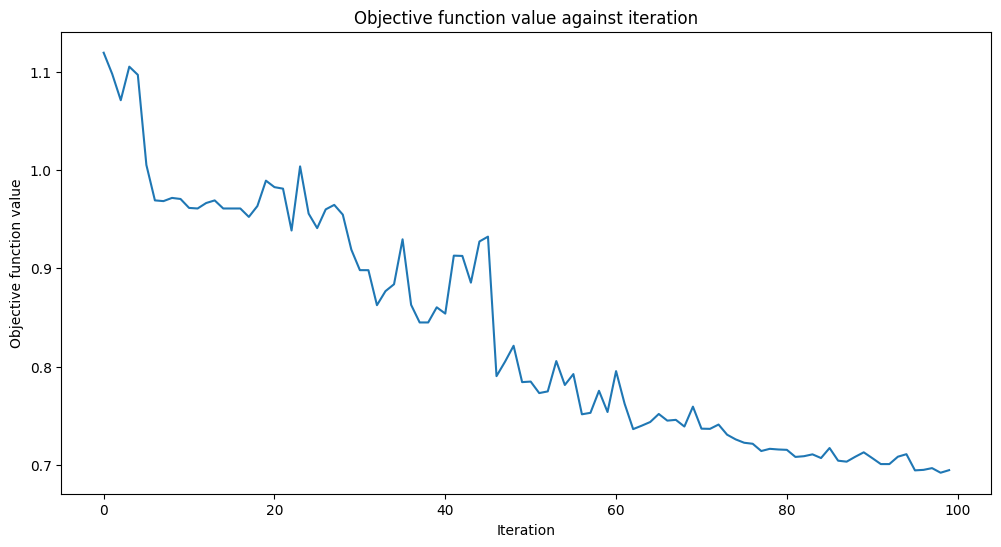

In [ ]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=q_optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_predictions_df, train_labels)
elapsed = time.time() - start

In [ ]:
train_score_q4 = vqc.score(train_predictions_df, train_labels)
test_score_q4 = vqc.score(test_predictions_df, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.90
Quantum VQC on the test dataset:     0.93


It turns out that the best performing model after encoding the data through PQAE is 93%. Completely outclassing the PCA encoding one which was 80%